In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")

In [4]:
   
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 110)

    n_presample = 10

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
  
 
 

100×4 Matrix{Float64}:
 0.009713     0.0106801   0.00224126    0.013337
 0.00957737   0.0103212   0.0247108     0.00177088
 0.00904995   0.011093   -0.00608481    0.0203842
 0.0120314    0.0114247  -0.000552857   0.0198336
 0.0101538    0.0112443   0.00278032    0.00940058
 0.00831622   0.0120842   0.0105462     0.00282064
 0.00815467   0.0123352   0.00133708    0.0139139
 0.00772933   0.0126253   0.0170876     0.0032981
 0.0104626    0.0141047   0.014014      0.00358578
 0.00898915   0.0137842   0.011639      0.00805665
 ⋮                                     
 0.00477547   0.0170539   0.00793086   -0.00528932
 0.00262197   0.0175235   0.0175337    -0.0188922
 0.00187906   0.015611    0.0411041    -0.0202719
 0.00236535   0.0161519   0.0198412    -0.00925899
 0.00506472   0.0156675   0.0128584    -0.00110803
 0.000523551  0.0147412  -0.0142107     0.0033509
 0.00213509   0.0154469  -0.0116719     0.00747927
 0.00234842   0.0166343  -0.004558      0.00215702
 0.00458794   0.0163717   0.

In [5]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])

0.024355018898445126

0.004203443522877309

In [6]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 0.019441  0.0308905

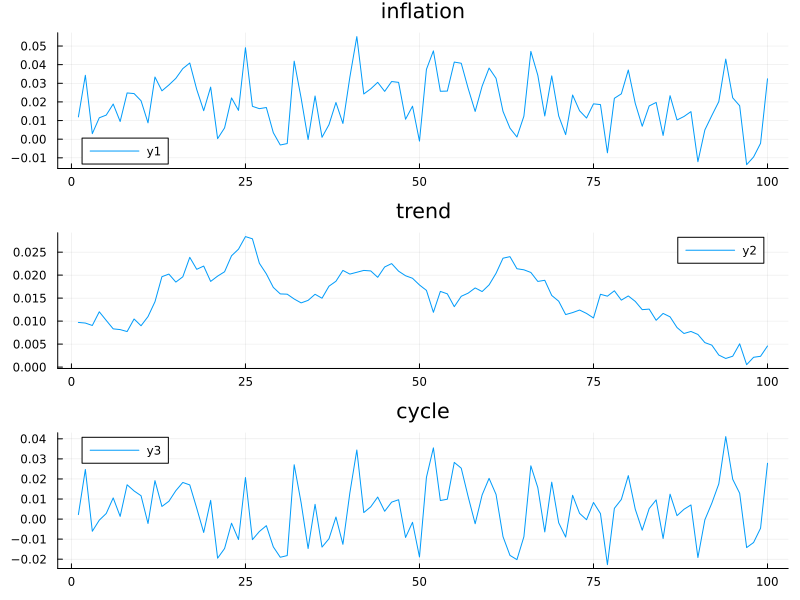

In [7]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

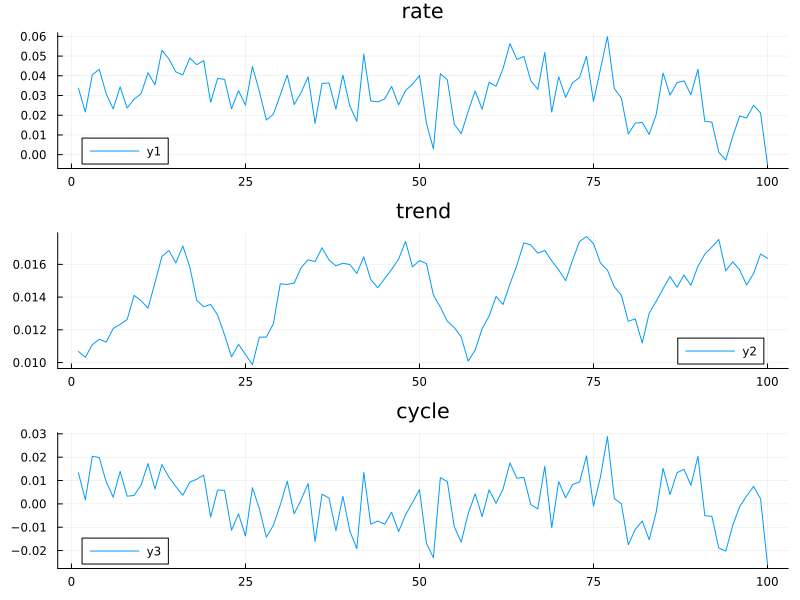

In [8]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [9]:
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        trend_covariance_df = 100,
        trend_covariance_mean = true_trend_covariance * (100 + 2 +1) #diagm([2, 1].^2/100) * (100 + 2 +1),
        )

(initial_trend_mean = [0.024355018898445126, 0.004203443522877309], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103])

In [216]:
model = tc_var(true_var_coeff, 
                true_trend_covariance, 
                true_cycle_covariance, 
                priors.initial_trend_mean, 
                true_initial_cycle_mean, 
                true_initial_trend_covariance, 
                true_initial_cycle_covariance
                )

StateSpaceModel([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.3 0.1; 0.0 0.0 0.4 0.6], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [1.0 0.0 1.0 0.0; 1.0 1.0 0.0 1.0], [4.0e-6 0.0 0.0 0.0; 0.0 1.0e-6 0.0 0.0; 0.0 0.0 0.000225 -0.00011549999999999997; 0.0 0.0 -0.00011549999999999997 0.00012099999999999999], [2.220446049250313e-16 0.0; 0.0 2.220446049250313e-16], [0.017884156566823337, 0.014142116442149213, 0.0, 0.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.000225 0.0; 0.0 0.0 0.0 0.00012099999999999999])

In [248]:
  state_filtered, covariance_filtred, state_predicted, covariance_predicted, ll = kalman_filter(model, data) 
   

   # Run Carter-Kohn sampler
    println("Running Carter-Kohn sampler...")
    state_smoothed_samples = carter_kohn_sampler2(model, data, n_samples=10_000)
   
    # Compute posterior statistics
    state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  
 

Running Carter-Kohn sampler...


([0.020586828279103818 0.01572145307647922 0.022051847496477317 -0.011174987683571556; 0.02057219460277137 0.015771018340773487 0.02967901244142164 -0.009458554172326421; … ; 0.0006527382145164937 0.016529899953428958 -0.018666779313516072 0.007031321585296112; 0.0011038126885685748 0.01656901059850052 0.012791648062787238 -0.010814985762820731], [0.00975040244318243 0.005450173897450584 0.011326422641385423 -0.02348991122740909; 0.01014165742853141 0.005719547171873691 0.019297332731147882 -0.021403527050586107; … ; -0.010021543592927935 0.006863519047168267 -0.0291617770540514 -0.004016681758253117; -0.009989108315867665 0.006636400310178586 0.0019547157345801173 -0.022000212256343875], [0.03129604918868403 0.025937231177132734 0.032883850446449626 0.0014321517959554988; 0.030973879927510047 0.025816764839417534 0.0401014743776387 0.0024969370515102152; … ; 0.011147922608096187 0.02643381185704865 -0.007997391635872923 0.01813585026328615; 0.011940729272258272 0.02658683141998209 0.0

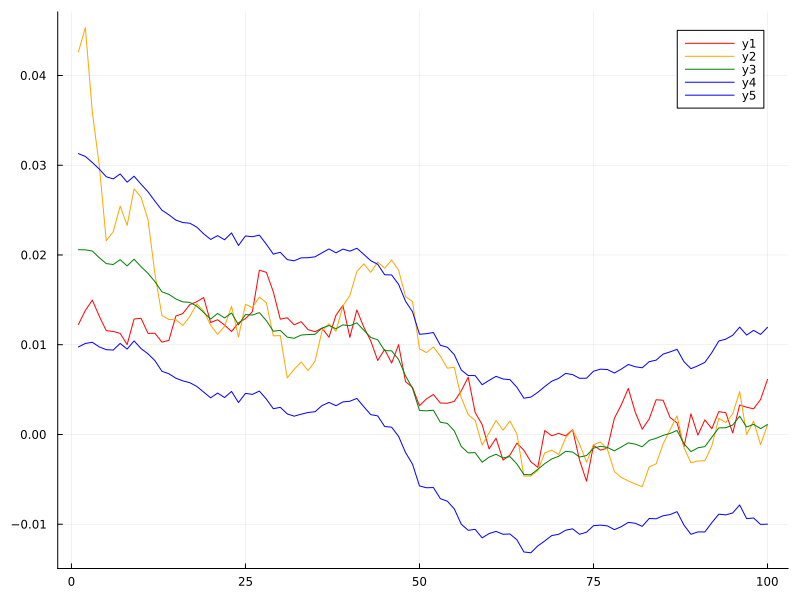

In [249]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

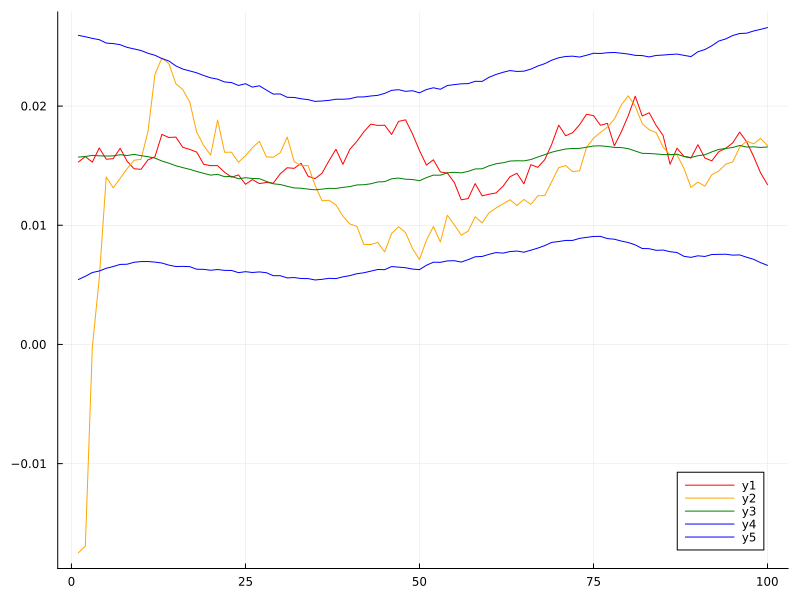

In [250]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

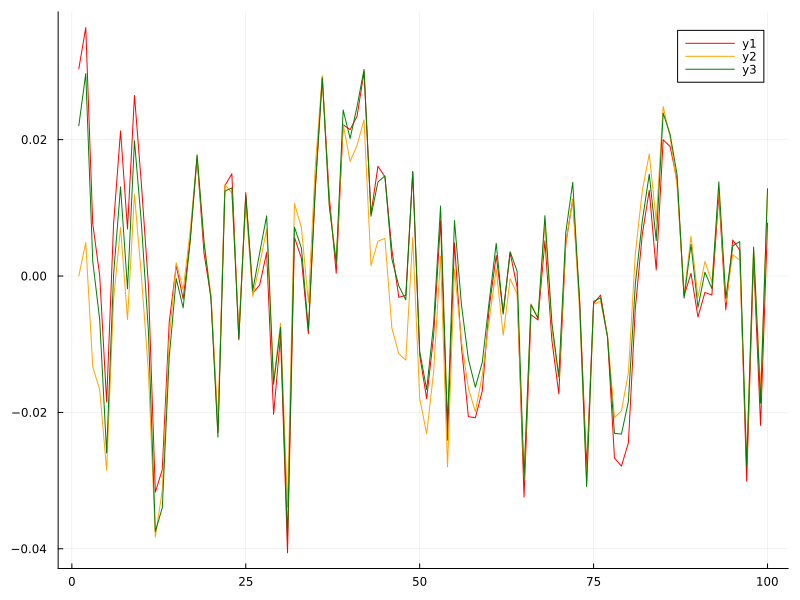

In [251]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

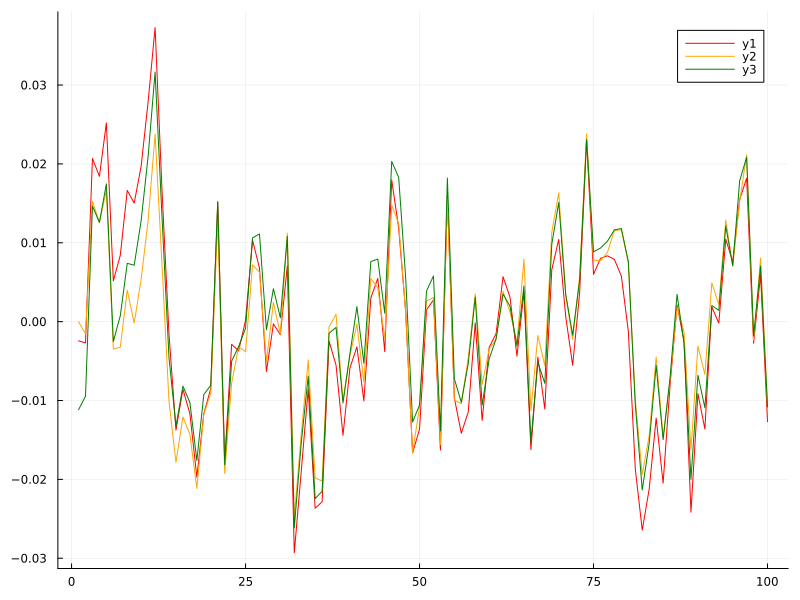

In [252]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [253]:
var_priors = minnesota_priors(data, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])
reshape(var_priors, 3, 2)

3×2 Matrix{Normal}:
 Normal{Float64}(μ=0.0, σ=0.2)         Normal{Float64}(μ=0.0, σ=0.159734)
 Normal{Float64}(μ=0.0, σ=0.250417)    Normal{Float64}(μ=0.0, σ=0.2)
 Normal{Float64}(μ=0.0, σ=0.00365744)  Normal{Float64}(μ=0.0, σ=0.00292108)

In [254]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 3.3891931297813587e-6
 7.945820748330059e-7

2-element Vector{Float64}:
 0.0018409761350385177
 0.0008913933334017065

In [255]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 199.0
Ψ: [0.0007475301198483545 -1.7782620521048055e-5; -1.7782620521048055e-5 0.00018166362540846757]
)


In [225]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
  0.000415389  -1.79622e-7
 -1.79622e-7    0.000103795

In [226]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.000381577  9.27449e-5

1×2 Matrix{Float64}:
 0.019534  0.00963041

0.02072064184083383

0.020357905248356727

In [227]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [228]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [229]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [230]:
[2, 1] .^2 / 100 

2-element Vector{Float64}:
 0.04
 0.01

In [231]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0205993  0.0103109

0.020667918824022836

0.022280988369509945

In [12]:
states = gibs_sampler(data, priors, 1000)

1000×100×4 Array{Float64, 3}:
[:, :, 1] =
 0.0310172     0.0294869    0.029336    …  0.00452567  0.00476988  0.00382967
 0.022257      0.0186939    0.0180638      0.00462347  0.00635665  0.00778012
 0.0246386     0.0239961    0.0216773      0.0109956   0.0124734   0.0140451
 0.0140504     0.0168467    0.0180417      0.00880756  0.00838415  0.00549707
 0.0291286     0.0298389    0.0268161      0.0085564   0.00989822  0.0096857
 0.0197363     0.0170096    0.015342    …  0.0101029   0.0086998   0.0105167
 0.026125      0.0251816    0.0248688      0.0147228   0.0132085   0.0137963
 0.0191927     0.0190832    0.0189145      0.0165035   0.0163312   0.0152585
 0.0114917     0.0138114    0.0145112      0.0101674   0.00904684  0.00983098
 0.0135235     0.0146782    0.0121333      0.0156526   0.0159418   0.0167342
 ⋮                                      ⋱                          
 0.000229442  -0.000443719  0.00222927     0.0111458   0.0117844   0.0120579
 0.0293354     0.029324     0.0269134  